[*********************100%***********************]  5 of 5 completed


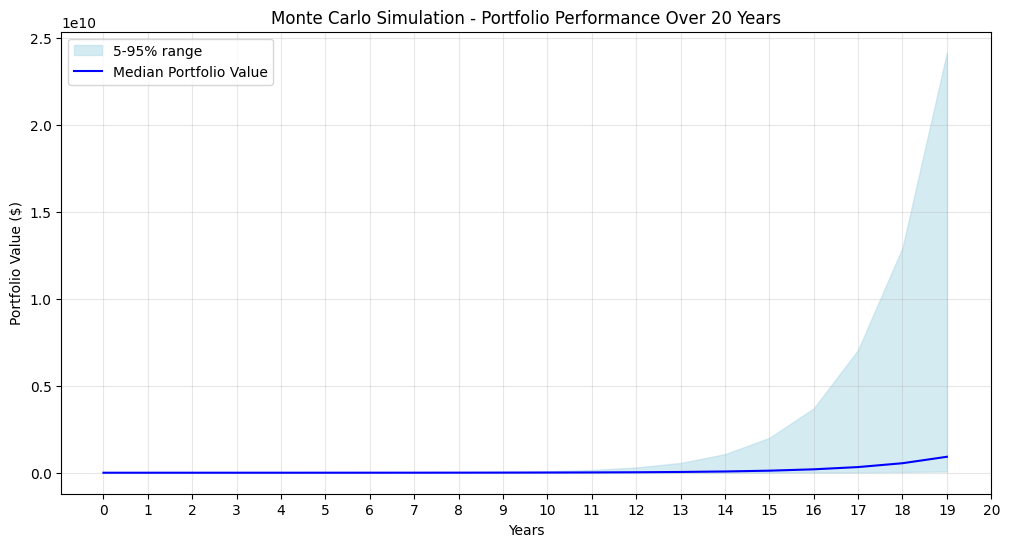

In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #to visualize results for now

#setup

tickers = ["AAPL", "NVDA", "MSFT", "GOOGL", "AMZN"]
portfolio_value = 250000 #250k portfolio
start_date ="2014-01-01" #start date of data
end_date ="2024-12-31" #end date of data
years = 20 #predicting # of years
trading_days = 252 * years #tradable days * desired years
num_simulations = 10000

#diving the percentage of the 250k equally beteween tickers
portfolio_division = {t: portfolio_value / len(tickers) for t in tickers}

#pulling from yfinance
data = yf.download(tickers, start="2014-01-01", end="2024-12-31", auto_adjust = True)
close_prices = data["Close"]
daily_returns = close_prices.pct_change().dropna() #getting our daily returns and dropping missing values

#simulation setup
spikes = np.random.normal(0, 1, (trading_days, num_simulations, len(tickers)))
last_prices = close_prices.iloc[-1]
port_mean = daily_returns.mean()
port_stdev = daily_returns.std()

sim_prices = np.zeros((trading_days, num_simulations, len(tickers)))
sim_prices[0, :, :] = last_prices.values  # start at last known prices

#simulation
for t in range(1, trading_days):
  sim_prices[t, :, :] = sim_prices[t-1, :, :] * np.exp((port_mean - 0.5 * port_stdev**2).values + port_stdev.values * spikes[t, :, :])

#computing the number of shares for each ticker
shares = np.array([portfolio_division[t] / last_prices[t] for t in tickers])

#port_values = sum of (price * shares) across tickers for all days and simulations
port_values = sim_prices @ shares

port_df = pd.DataFrame(port_values)
port_df.index.name = "Day"

#DATA VISUALIZATION TESTING - NEED TO IMPROVE ON REMOVING OUTLIERS

# Aggregate to yearly values
years_axis = port_df.index / 252  # convert to years
yearly_indices = np.arange(0, trading_days, 252)  # every year

port_df_yearly = port_df.iloc[yearly_indices]

# Percentiles for yearly aggregation
p5_yearly = port_df_yearly.quantile(0.05, axis=1)
median_yearly = port_df_yearly.quantile(0.5, axis=1)
p95_yearly = port_df_yearly.quantile(0.95, axis=1)
years_axis_yearly = years_axis[yearly_indices]

# Plot
plt.figure(figsize=(12,6))
plt.fill_between(years_axis_yearly, p5_yearly, p95_yearly, color='lightblue', alpha=0.5, label='5-95% range')
plt.plot(years_axis_yearly, median_yearly, color='blue', label='Median Portfolio Value')
plt.xlabel("Years")
plt.ylabel("Portfolio Value ($)")
plt.title(f"Monte Carlo Simulation - Portfolio Performance Over {years} Years")
plt.xticks(np.arange(0, years+1, 1))
plt.grid(alpha=0.3)
plt.legend()
plt.show()